In [165]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelBinarizer, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectFpr, RFECV
from sklearn.svm import SVR
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Считаем данные и предобратаем так, как сказано в документации к данному датасету http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt (уберем выбросы и не типичные значения SalePrice, затем ее прологорифмируем)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
id_test = test['Id']
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
train = train.drop(train[(train['GrLivArea']>4000)].index)
y = train.SalePrice.values
y = np.log1p(y)
all_data = pd.concat([train,test]).reset_index(drop=True)
all_data.drop('SalePrice',axis=1, inplace=True)

In [3]:
all_data['GarageYrBlt'].describe()

count    2756.000000
mean     1978.079826
std        25.576507
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [4]:
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].replace({2207:2007})

Text(0.5,1,'Цена дома в зависимости от его площади')

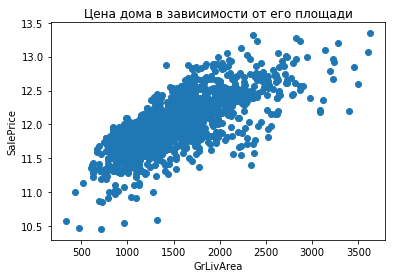

In [5]:
# после уборки выбросов
plt.scatter(x = train.GrLivArea, y=y)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title(u'Цена дома в зависимости от его площади')

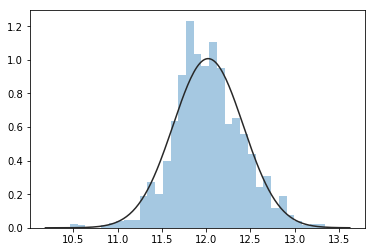

In [6]:
sns.distplot(y, kde=False, fit=stats.norm)

In [7]:
print(u'objects in train dataset: {}'.format(train.shape[0]))
print(u'objects in test dataset: {}'.format(test.shape[0]))

objects in train dataset: 1456
objects in test dataset: 1459


In [8]:
# выведем все столбцы, где есть NaN значения
all_data.isnull().sum().sort_values(ascending=False)[:35]

PoolQC          2907
MiscFeature     2810
Alley           2717
Fence           2345
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
Electrical         1
Exterior2nd        1
KitchenQual        1
GarageCars         1
Exterior1st        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
Condition2         0
dtype: int64

In [9]:
# посмотрим повнимательнее на признаки гаражей и подвалов
temp_data = all_data[['GarageFinish', 'GarageYrBlt', 'GarageType','GarageQual', 'GarageArea', 'GarageCars', 'GarageCond']]
temp_data[(temp_data['GarageYrBlt'].isnull())&(temp_data['GarageType'].isnull()==False)]

,GarageFinish,GarageYrBlt,GarageType,GarageQual,GarageArea,GarageCars,GarageCond
2122,NaN,NaN,Detchd,NaN,360.0,1.0,NaN
2572,NaN,NaN,Detchd,NaN,NaN,NaN,NaN


Видим, что есть 2 дома, у которых гараж отеделен от дома и все поля кроме GarageType заполнены NaN. Эти объекты в тесте, что значит надо заполнять эти NaN не так, как было бы при  отсутствии гаража

In [10]:
# раз здесь стоят NaN, то гаражи скорее всего не закончены
all_data.loc[2122 ,'GarageFinish'] = 'Unf'
all_data.loc[2572 ,'GarageFinish'] = 'Unf'
# c годами сложнее, поставим просто среднее
all_data.loc[2122 ,'GarageYrBlt'] = all_data['GarageYrBlt'][all_data['GarageFinish'] == 'Unf'].median()
all_data.loc[2572 ,'GarageYrBlt'] = all_data['GarageYrBlt'][all_data['GarageFinish'] == 'Unf'].median()
#GarageQual и GarageCond выберем самый популярный
all_data.loc[2122, 'GarageQual'] = all_data['GarageQual'].mode()[0]
all_data.loc[2572, 'GarageQual'] = all_data['GarageQual'].mode()[0]
all_data.loc[2122, 'GarageCond'] = all_data['GarageQual'].mode()[0]
all_data.loc[2572, 'GarageCond'] = all_data['GarageQual'].mode()[0]
#GarageArea и GarageCars отсутсвует только у второго объекта
all_data.loc[2572, 'GarageArea'] = all_data['GarageArea'].median()
all_data.loc[2572, 'GarageCars'] = all_data['GarageCars'].median()

In [11]:
# посмотрим повнимательнее на признаки наличия бассейна
temp_data = all_data[['PoolQC', 'PoolArea']]
temp_data[(temp_data['PoolQC'].isnull())&(temp_data['PoolArea']>0)]

,PoolQC,PoolArea
2416,NaN,368
2499,NaN,444
2595,NaN,561


In [12]:
# заполним NaN в PoolQC в соответсвии с качеством домов
print(all_data.loc[2416][['GarageQual', 'KitchenQual', 'BsmtQual','OverallQual']])
print(all_data.loc[2499][['GarageQual', 'KitchenQual', 'BsmtQual','OverallQual']])
print(all_data.loc[2595][['GarageQual', 'KitchenQual', 'BsmtQual','OverallQual']])

GarageQual     TA
KitchenQual    TA
BsmtQual       TA
OverallQual     4
Name: 2416, dtype: object
GarageQual     TA
KitchenQual    Gd
BsmtQual       TA
OverallQual     6
Name: 2499, dtype: object
GarageQual      TA
KitchenQual     TA
BsmtQual       NaN
OverallQual      3
Name: 2595, dtype: object


In [13]:
all_data['PoolQC'][all_data['PoolQC'].isnull() == False].value_counts()

Ex    3
Gd    3
Fa    2
Name: PoolQC, dtype: int64

In [14]:
# у нас нет в обучабщих данных типа TA для PoolQC
all_data.loc[2416, 'PoolQC'] = 'Fa'
all_data.loc[2499, 'PoolQC'] = 'Gd'
all_data.loc[2595, 'PoolQC'] = 'Fa'

In [15]:
# разберемся с признаками для подвала
temp_data = all_data[['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                      'BsmtQual', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2','TotalBsmtSF']]

In [16]:
temp_data[(temp_data.isnull().sum(axis=1) < 5)&(temp_data.isnull().sum(axis=1) > 0)]

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
332,TA,No,GLQ,NaN,Gd,1603.0,1124.0,479.0,3206.0
946,TA,NaN,Unf,Unf,Gd,936.0,0.0,0.0,936.0
1483,TA,NaN,Unf,Unf,Gd,1595.0,0.0,0.0,1595.0
2036,NaN,Mn,GLQ,Rec,Gd,0.0,1044.0,382.0,1426.0
2181,NaN,No,BLQ,Unf,TA,94.0,1033.0,0.0,1127.0
2213,Fa,No,Unf,Unf,NaN,173.0,0.0,0.0,173.0
2214,TA,No,Unf,Unf,NaN,356.0,0.0,0.0,356.0
2344,TA,NaN,Unf,Unf,Gd,725.0,0.0,0.0,725.0
2520,NaN,Av,ALQ,Unf,TA,240.0,755.0,0.0,995.0


In [17]:
print(all_data.loc[2213][['GarageQual', 'KitchenQual', 'OverallQual']])
print(all_data.loc[2214][['GarageQual', 'KitchenQual', 'OverallQual']])

GarageQual     Fa
KitchenQual    TA
OverallQual     4
Name: 2213, dtype: object
GarageQual     Po
KitchenQual    TA
OverallQual     4
Name: 2214, dtype: object


In [18]:
# заполняем недостующие значения
all_data.loc[2036, 'BsmtCond'] = all_data['BsmtCond'].mode()[0]
all_data.loc[2181, 'BsmtCond'] = all_data['BsmtCond'].mode()[0]
all_data.loc[2520, 'BsmtCond'] = all_data['BsmtCond'].mode()[0]
all_data.loc[946, 'BsmtExposure'] = 'No'
all_data.loc[1483, 'BsmtExposure'] = 'No'
all_data.loc[2344, 'BsmtExposure'] = 'No'
all_data.loc[2213, 'BsmtQual'] = 'Po'
all_data.loc[2214, 'BsmtQual'] = 'Fa'
all_data.loc[332, 'BsmtFinType2'] = 'GLQ'

In [19]:
# заполняем оставшиеся NaN
all_data['Functional'].fillna('Typ', inplace=True)
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['Utilities'] = all_data['Utilities'].mode()[0]

In [20]:
# fill another NaN's
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu','GarageFinish',
            'GarageQual','GarageCond','GarageType', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure','BsmtFinType1', 'BsmtFinType2','MasVnrType','MSSubClass']:
    all_data[col].fillna('doesnt_exist',inplace=True )
for col in ['GarageYrBlt','GarageCars', 'GarageArea','MasVnrArea','BsmtHalfBath',
            'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath']:
    all_data[col].fillna(0, inplace=True)
for col in ['KitchenQual', 'SaleType', 'Exterior1st','Exterior2nd', 'Electrical', 'MSZoning']:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)

In [21]:
all_data.isnull().sum().sort_values(ascending=False)[0]
# больше не осталось NaN значений

0

**Feature engineering**

In [22]:
# Заменяем строковые признаки качества оценками
all_data= all_data.replace({       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        'BsmtQual' : {"doesnt_exist" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                        'BsmtCond' : {"doesnt_exist" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        'BsmtExposure': {"doesnt_exist" : -1,"No":0, "Mn" : 1, "Av": 2, "Gd" : 3},
                        'GarageCond': {"doesnt_exist" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        'GarageQual': {"doesnt_exist" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                        'FireplaceQu': {"doesnt_exist" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
               }
                     )

In [23]:
# применяем Label encoding к оставшимся категориальным признакам
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
cols = ('PoolQC', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [24]:
all_data.to_csv('preprocess_data.csv', index=False)

In [25]:
# добавим новых признаков
extended_features = pd.DataFrame()
# больше ли 2 машин находится в гараже?
extended_features['Number_cars'] = all_data['GarageCars'].apply(lambda x: 0 if x <2 else 1)
# упрощение качества гаража
extended_features['new_Garage_Qual'] = all_data['GarageQual'].apply(lambda x: 0 if x <3 else 1)
# общая оценка гаража
extended_features['Grage_grade'] = all_data['GarageQual'] + all_data['GarageCond']
extended_features['Garage_smth'] = all_data['GarageCars']*all_data['GarageArea']
# общая площадь законченного подвала
extended_features['BsmtSf_all'] = all_data.BsmtFinSF1 + all_data.BsmtFinSF2
# все ванны
extended_features['All_baths'] = all_data.FullBath + 0.5*all_data.HalfBath + all_data.BsmtFullBath + 0.5*all_data.BsmtHalfBath
# общая оценка гаража
extended_features['fireplaces'] = all_data.FireplaceQu*all_data.Fireplaces
# преобразование HeatinQC в бинарное
extended_features['Heatin_bin'] = all_data['HeatingQC'].apply(lambda x: 0 if x<4 else 1)
# построен ли дом в 21 веке?
extended_features['21_century_1'] = all_data['YearBuilt'].apply(lambda x: 1 if x >1999 else 0)
# был ли ремонт в 21 веке?
extended_features['21_century_2'] = all_data['YearRemodAdd'].apply(lambda x: 1 if x >1999 else 0)
# общая площадь
extended_features['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
extended_features.to_csv('ext_1.csv', index=False)

In [93]:
extended_features = pd.DataFrame()
extended_features['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

extended_features['Total_Bathrooms'] = (all_data['FullBath'] + (0.5*all_data['HalfBath']) + 
                               all_data['BsmtFullBath'] + (0.5*all_data['BsmtHalfBath']))

extended_features['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                             all_data['WoodDeckSF'])


#признаки типа есть ли бассейн, второй этаж, гараж и т.д.
extended_features['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
extended_features['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
extended_features['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
extended_features['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
extended_features['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
extended_features.to_csv('ext_2.csv', index=False) 

In [149]:
all_data = pd.read_csv('preprocess_data.csv')

In [150]:
# mean encoding для признаков с большим количеством значений
extended_features = pd.DataFrame()
train = all_data[:train.shape[0]]
train['SalePrice'] = y
cols_1 = ['SalePrice', 'LotArea']
cols_2 = ['Neighborhood', 'Condition1', 'Condition2', 'SaleType', 'Exterior1st', 'Exterior2nd', 'MSSubClass', 'MSZoning']
for c2 in cols_2:
    for c1 in cols_1:
        gb = train[[c2, c1]].groupby(c2).mean().reset_index()
        all_data = all_data.merge(gb, how='left', on=c2)
all_data.drop(cols_2, axis=1, inplace=True)
all_data = all_data.fillna(0)
all_data.to_csv('mean_encode.csv', index=False)

In [29]:
# предобработка данных, избавление от ассиметрии некоторых признаков 
def predob(all_data):
    numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index
    skewed_feats = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        all_data[feat] = boxcox1p(all_data[feat], lam)
    return all_data

In [151]:
# сохраняем все полученные датасеты
# dataset with mean_encoding
all_data = pd.read_csv('mean_encode.csv')
all_data = predob(all_data)
all_data = pd.get_dummies(all_data)
all_data.to_csv('mean_encode.csv', index=False)

In [68]:
# data without extended features
all_data = pd.read_csv('preprocess_data.csv')
all_data = predob(all_data)
all_data = pd.get_dummies(all_data)
all_data.to_csv('just_data.csv', index=False)

In [66]:
# dataset with ext_1 features
all_data = pd.read_csv('preprocess_data.csv')
ext_1 = pd.read_csv('ext_1.csv')
all_data = pd.concat([all_data, ext_1], axis=1).reset_index(drop=True)
all_data = predob(all_data)
all_data = pd.get_dummies(all_data)
all_data.to_csv('data_with_ext_1.csv', index=False)

In [94]:
# dataset with ext_2 features
all_data = pd.read_csv('preprocess_data.csv')
ext_2 = pd.read_csv('ext_2.csv')
all_data = pd.concat([all_data, ext_2], axis=1).reset_index(drop=True)
all_data = predob(all_data)
all_data = pd.get_dummies(all_data)
all_data.to_csv('data_with_ext_2.csv', index=False)

**Buliding models**

In [154]:
# будем пользоваться валидацией по индексам, так же разделены train и test данные
cv = KFold(3, shuffle=False)
answers = []

In [186]:
all_data = pd.read_csv('just_data.csv')
train_df = all_data[:train.shape[0]]
test_df = all_data[train.shape[0]:]

0.0005


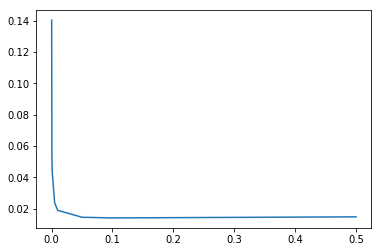

In [104]:
# найдем оптимальные параметры для моделей
alphas1 = [0.0001, 0.0005, 0.001, 0.005, 0.01,0.05, 0.1, 0.5]
las = LassoCV(alphas=alphas1, cv=cv, n_jobs=-1, random_state=1)
all_data = pd.read_csv('just_data.csv')
train_df = all_data[:train.shape[0]]
test_df = all_data[train.shape[0]:]
las.fit(train_df, y)
print(las.alpha_)
plt.plot(alphas1,las.mse_path_.mean(axis=1))

best alpha for Lasso: 0.0004


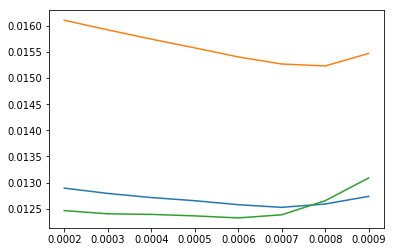

In [161]:
alphas2 = [0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009]
las = LassoCV(alphas=alphas2, cv=cv, n_jobs=-1, random_state=1)
las.fit(train_df, y)
print('best alpha for Lasso: {}'.format(las.alpha_))
plt.plot(alphas2,las.mse_path_)
answers.append(las.predict(test_df))

In [112]:
rid = RidgeCV(alphas =[0.1, 0.5, 1,5, 10], cv=cv)
rid.fit(train_df, y)
print('best alpha for rid, step 1: {}'.format(rid.alpha_))

5


In [160]:
rid = RidgeCV(alphas =[3,4,5,6,7,8,9], cv=cv)
rid.fit(train_df, y)
print('best alpha for rid: {}'.format(rid.alpha_))
answers.append(rid.predict(test_df))

best alpha for rid: 7


In [174]:
# найдем оптимальное C для SVM 
grid = {'C': [0.1,0.5,1,5,10]}
svm = SVR()
search = GridSearchCV(svm, grid, cv=cv, n_jobs=-1)
search.fit(train_df, y)
print('best C for SVM: {}'.format(search.best_params_['C']))
print('cv result: {}'.format(search.best_score_))

best C for SVM: 1
cv result: 0.8457753095228316


In [192]:
# найдем оптимальные параметры для RandomForest
grid = {
    'n_estimators': [10,100,500],
    'max_features': [0.99, 0.8,0.5],
    'min_samples_leaf': [1,2]
}
rf = RandomForestRegressor(random_state=1, n_jobs=-1)
rf_search = GridSearchCV(rf, grid, cv=cv, n_jobs=-1, error_score=mean_squared_error)
rf_search.fit(train_df,y)
print(rf_search.best_params_)

{'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 500}


In [194]:
grid = {
    'n_estimators': [300,500,1000],
    'max_features': [0.7,0.6,0.5]    
}
rf_search = GridSearchCV(rf, grid, cv=cv, n_jobs=-1, error_score=mean_squared_error)
rf_search.fit(train_df,y)
print(rf_search.best_params_)

{'max_features': 0.5, 'n_estimators': 1000}


In [181]:
# возьмем XGB и LGB с уже подобранными гиперпараметрами
xgb3 = xgb.XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)
lgb3 = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11)

In [202]:
# пара функций для валидации
def cross_validation(model, train_df):
    a = []
    kfold = KFold(3, shuffle=False)
    for train_ind, valid_ind in kfold.split(train_df):
        tr, val = train_df.iloc[train_ind], train_df.iloc[valid_ind]
        y_tr, y_val = y[train_ind], y[valid_ind]
        model.fit(tr, y_tr)
        preds = model.predict(val)
        a.append(mean_squared_error(y_val, preds))
    return a

In [208]:
def data_validate(path, methods):
    all_data = pd.read_csv(path)
    train_df = all_data[:train.shape[0]]
    for method in methods:
        a = cross_validation(method, train_df)
        print('model {}. score {}'.format(method, np.mean(a)))
        print('-'*50)

In [209]:
# проверим наши модели на разных датасетах
lasso = Lasso(alpha=0.0004)
ridge = Ridge(alpha=7)
rf = RandomForestRegressor(n_jobs=-1, random_state=10, n_estimators=1000, max_features=0.5)
svr = SVR(C=1) 
methods = [lasso, ridge, rf,svr, xgb3, lgb3]
data_validate('just_data.csv', methods)

model Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False). score 0.014113128881550556
--------------------------------------------------
model Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001). score 0.014341998658613039
--------------------------------------------------
model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False). score 0.018230971774405573
--------------------------------------------------
model SVR(C=1, cache_size=200, coef0=0.0, 

In [210]:
data_validate('data_with_ext_1.csv', methods)

model Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False). score 0.013391148338546
--------------------------------------------------
model Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001). score 0.01383713770852142
--------------------------------------------------
model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False). score 0.017909623856553755
--------------------------------------------------
model SVR(C=1, cache_size=200, coef0=0.0, degr

In [211]:
data_validate('data_with_ext_2.csv', methods)

model Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False). score 0.013975137204376669
--------------------------------------------------
model Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001). score 0.014213603073675743
--------------------------------------------------
model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False). score 0.017946625099128716
--------------------------------------------------
model SVR(C=1, cache_size=200, coef0=0.0, 

In [212]:
data_validate('mean_encode.csv', methods)

model Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False). score 0.015802377505184595
--------------------------------------------------
model Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001). score 0.016431218886116844
--------------------------------------------------
model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=10, verbose=0, warm_start=False). score 0.017900751531693994
--------------------------------------------------
model SVR(C=1, cache_size=200, coef0=0.0, 

In [213]:
# отберем лучшие модели и усредним их предсказания
all_data = pd.read_csv('data_with_ext_1.csv')
train_df = all_data[:train.shape[0]]
test_df = all_data[train.shape[0]:]
answers= []
las.fit(train_df, y)
answers.append(las.predict(test_df))
rid.fit(train_df,y)
answers.append(rid.predict(test_df))
svr.fit(train_df,y)
answers.append(svr.predict(test_df))
rf.fit(train_df,y)
answers.append(rf.predict(test_df))
lgb3.fit(train_df,y)
answers.append(lgb3.predict(test_df))
all_data = pd.read_csv('data_with_ext_2.csv')
train_df = all_data[:train.shape[0]]
test_df = all_data[train.shape[0]:]
las.fit(train_df, y)
answers.append(las.predict(test_df))
rf.fit(train_df, y)
answers.append(rf.predict(test_df))
xgb3.fit(train_df, y)
answers.append(xgb3.predict(test_df))
all_data = pd.read_csv('mean_encode.csv')
train_df = all_data[:train.shape[0]]
test_df = all_data[train.shape[0]:]
lgb3.fit(train_df, y)
answers.append(lgb3.predict(test_df))
rf.fit(train_df, y)
answers.append(rf.predict(test_df))
xgb3.fit(train_df, y)
answers.append(xgb3.predict(test_df))

In [214]:
# запись ответов
ans = pd.DataFrame({'Id': id_test, 'SalePrice':np.exp(np.mean(answers, axis=0))})
ans.to_csv('final_answers_ensemble.csv', index=False)